# Nettverksanalyse i sgis
https://github.com/statisticsnorway/ssb-sgis

Notebook-en kan kjøres i dapla hvis man har tilgang til bøtta 'kart'.

Eller åpnes her: https://nbviewer.org/github/statisticsnorway/intro_til_geopandas/blob/main/nettverksanalyse.ipynb

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import sgis as sg

## Hente data

Henter bygningspunkter i Oslo.

In [ ]:
aar = 2022
kommnr = "0301"

bygningspunktsti = f"ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data/{aar}/SMAT_bygg_punkt_p{aar}_v1.parquet"

bygg = sg.read_geopandas(
    bygningspunktsti,
    filters=[("KOMMUNENR", "=", kommnr)],
    columns=["KOMMUNENR", "geometry"]
)

Lager noen start- og sluttpunkter.

In [ ]:
origins = bygg.sample(1000)
origins.index = np.arange(0, 1000)
origins

geometry
0    POINT (266614.000 6651112.000)
1    POINT (262504.000 6651834.000)
2    POINT (267803.000 6645192.000)
3    POINT (266455.000 6648285.000)
4    POINT (266424.000 6662117.000)
..                              ...
995  POINT (265153.000 6645633.000)
996  POINT (265882.000 6651289.000)
997  POINT (263389.000 6641680.000)
998  POINT (272332.000 6653772.000)
999  POINT (264305.000 6644598.000)

[1000 rows x 1 columns]

In [ ]:
destinations = bygg.sample(1000)
destinations.index = np.arange(1000, 2000)
destinations

geometry
1000  POINT (267480.000 6638510.000)
1001  POINT (260461.000 6646807.000)
1002  POINT (273005.000 6653557.000)
1003  POINT (263922.000 6650971.000)
1004  POINT (256433.000 6650258.000)
...                              ...
1995  POINT (265390.000 6652485.000)
1996  POINT (267514.000 6648294.000)
1997  POINT (265541.000 6648730.000)
1998  POINT (268350.000 6653532.000)
1999  POINT (267275.000 6641155.000)

[1000 rows x 1 columns]

Henter vegdata i Oslo for 2022 med relevante kolonner: fart og retning.

In [ ]:
kartdata = "ssb-prod-kart-data-delt/kartdata_analyse/klargjorte-data"

veger_oslo = (
    sg.read_geopandas(
        f"{kartdata}/2022/NVDB_ruteplan_nettverk_p20220703_v1.parquet",
        filters=[("KOMMUNENR", "=", kommnr)],
        columns=["oneway", "drivetime_fw", "drivetime_bw", "KOMMUNENR", "geometry"]
    )
    .sort_values("oneway")
    .reset_index(drop=True)
)

veger_oslo

oneway  drivetime_fw  drivetime_bw KOMMUNENR  \
0          B      0.216611      0.216611      0301   
1          B      0.064631      0.064631      0301   
2          B      0.023387      0.023387      0301   
3          B      0.174470      0.174470      0301   
4          B      0.085934      0.085934      0301   
...      ...           ...           ...       ...   
93390     TF     -1.000000      0.003683      0301   
93391     TF     -1.000000      0.031986      0301   
93392     TF     -1.000000      0.010607      0301   
93393     TF     -1.000000      0.004257      0301   
93394     TF     -1.000000      0.128560      0301   

                                                geometry  
0      MULTILINESTRING Z ((258028.440 6674249.890 413...  
1      MULTILINESTRING Z ((263329.703 6652880.398 88....  
2      MULTILINESTRING Z ((270274.700 6651212.900 154...  
3      MULTILINESTRING Z ((267240.000 6644124.500 133...  
4      MULTILINESTRING Z ((273365.300 6652133.100 174...  
...                                                  ...  
93390  MULTILINESTRING Z ((263871.009 6648498.376 29....  
93391  MULTILINESTRING Z ((267727.200 6649124.300 155...  
93392  MULTILINESTRING Z ((263871.400 6648500.800 29....  
93393  MULTILINESTRING Z ((256561.560 6651007.630 63....  
93394  MULTILINESTRING Z ((262522.672 6651527.844 52....  

[93395 rows x 5 columns]

## Gjør klar til nettverksanalyse

Før vegene kan brukes i nettverksanalyse med retning, må det gjøres noen tilpasninger.

1) Man må duplisere og snu vegene som går begge retninger (oneway=="B").

2) Snu vegene som går i motsatt retning (oneway=="TF").

In [ ]:
antall_per_retning = veger_oslo.oneway.value_counts().to_frame()

antall_per_retning["hva_må_gjøres"] = {"B": "Duplisere og snu duplikatene", "TF": "Snu", "FT": "Ingenting"}

antall_per_retning

oneway                 hva_må_gjøres
B    82230  Duplisere og snu duplikatene
FT    7353                     Ingenting
TF    3812                           Snu

3) Man må også lage en minutt-kolonne av kjøretid-kolonnene.

In [ ]:
veger_oslo[["oneway", "drivetime_fw", "drivetime_bw"]]

oneway  drivetime_fw  drivetime_bw
0          B      0.216611      0.216611
1          B      0.064631      0.064631
2          B      0.023387      0.023387
3          B      0.174470      0.174470
4          B      0.085934      0.085934
...      ...           ...           ...
93390     TF     -1.000000      0.003683
93391     TF     -1.000000      0.031986
93392     TF     -1.000000      0.010607
93393     TF     -1.000000      0.004257
93394     TF     -1.000000      0.128560

[93395 rows x 3 columns]

Dette kan gjøres sånn her:

In [ ]:
veger_med_retning = sg.make_directed_network_norway(veger_oslo)
veger_med_retning

oneway   minutes KOMMUNENR  \
0           B  0.216611      0301   
1           B  0.064631      0301   
2           B  0.023387      0301   
3           B  0.174470      0301   
4           B  0.085934      0301   
...       ...       ...       ...   
175620     TF  0.003683      0301   
175621     TF  0.031986      0301   
175622     TF  0.010607      0301   
175623     TF  0.004257      0301   
175624     TF  0.128560      0301   

                                                 geometry  
0       MULTILINESTRING Z ((258028.440 6674249.890 413...  
1       MULTILINESTRING Z ((263329.703 6652880.398 88....  
2       MULTILINESTRING Z ((270274.700 6651212.900 154...  
3       MULTILINESTRING Z ((267240.000 6644124.500 133...  
4       MULTILINESTRING Z ((273365.300 6652133.100 174...  
...                                                   ...  
175620  MULTILINESTRING Z ((263871.400 6648500.800 29....  
175621  MULTILINESTRING Z ((267749.000 6649137.700 156...  
175622  MULTILINESTRING Z ((263874.800 6648507.000 29....  
175623  MULTILINESTRING Z ((256560.200 6651010.200 63....  
175624  MULTILINESTRING Z ((262543.865 6651593.052 54....  

[175541 rows x 4 columns]

Eller en mer generell variant:

In [ ]:
veger_med_retning = sg.make_directed_network(
    veger_oslo,
    direction_col="oneway",
    direction_vals_bft=("B", "FT", "TF"),
    minute_cols=("drivetime_fw", "drivetime_bw"),
)

veger_med_retning

oneway   minutes KOMMUNENR  \
0           B  0.216611      0301   
1           B  0.064631      0301   
2           B  0.023387      0301   
3           B  0.174470      0301   
4           B  0.085934      0301   
...       ...       ...       ...   
175620     TF  0.003683      0301   
175621     TF  0.031986      0301   
175622     TF  0.010607      0301   
175623     TF  0.004257      0301   
175624     TF  0.128560      0301   

                                                 geometry  
0       MULTILINESTRING Z ((258028.440 6674249.890 413...  
1       MULTILINESTRING Z ((263329.703 6652880.398 88....  
2       MULTILINESTRING Z ((270274.700 6651212.900 154...  
3       MULTILINESTRING Z ((267240.000 6644124.500 133...  
4       MULTILINESTRING Z ((273365.300 6652133.100 174...  
...                                                   ...  
175620  MULTILINESTRING Z ((263871.400 6648500.800 29....  
175621  MULTILINESTRING Z ((267749.000 6649137.700 156...  
175622  MULTILINESTRING Z ((263874.800 6648507.000 29....  
175623  MULTILINESTRING Z ((256560.200 6651010.200 63....  
175624  MULTILINESTRING Z ((262543.865 6651593.052 54....  

[175541 rows x 4 columns]

In [ ]:
print("Kilometer før:", veger_oslo.length.sum() / 1000)
print("Kilometer nå:", veger_med_retning.length.sum() / 1000)

Kilometer før: 3851.4819685472407
Kilometer nå: 7248.592623912765


In [ ]:
veger_med_retning.minutes

0         0.216611
1         0.064631
2         0.023387
3         0.174470
4         0.085934
            ...   
175620    0.003683
175621    0.031986
175622    0.010607
175623    0.004257
175624    0.128560
Name: minutes, Length: 175541, dtype: float64

4) Man bør også fjerne isolerte nettverksøyer. Dette er gjerne veger bak bommer (innkjørsler, inni borettslag).

Sånn her kan man finne nettverksøyene:

In [12]:
veger_med_retning = sg.get_connected_components(veger_med_retning)
veger_med_retning

oneway   minutes KOMMUNENR  \
0           B  0.216611      0301   
1           B  0.064631      0301   
2           B  0.023387      0301   
3           B  0.174470      0301   
4           B  0.085934      0301   
...       ...       ...       ...   
175620     TF  0.003683      0301   
175621     TF  0.031986      0301   
175622     TF  0.010607      0301   
175623     TF  0.004257      0301   
175624     TF  0.128560      0301   

                                                 geometry  connected  
0       LINESTRING Z (258028.440 6674249.890 413.751, ...        0.0  
1       LINESTRING Z (263329.703 6652880.398 88.022, 2...        1.0  
2       LINESTRING Z (270274.700 6651212.900 154.767, ...        0.0  
3       LINESTRING Z (267240.000 6644124.500 133.461, ...        1.0  
4       LINESTRING Z (273365.300 6652133.100 174.571, ...        1.0  
...                                                   ...        ...  
175620  LINESTRING Z (263871.400 6648500.800 29.259, 2...        1.0  
175621  LINESTRING Z (267749.000 6649137.700 156.064, ...        1.0  
175622  LINESTRING Z (263874.800 6648507.000 29.759, 2...        1.0  
175623  LINESTRING Z (256560.200 6651010.200 63.654, 2...        1.0  
175624  LINESTRING Z (262543.865 6651593.052 54.090, 2...        1.0  

[175541 rows x 5 columns]

In [13]:
sg.samplemap(veger_med_retning, "connected")

Fjerne nettverksøyene:

In [14]:
veger_ned_tilknytning = veger_med_retning[veger_med_retning.connected == 1]
veger_ned_tilknytning

oneway   minutes KOMMUNENR  \
1           B  0.064631      0301   
3           B  0.174470      0301   
4           B  0.085934      0301   
5           B  0.119831      0301   
6           B  0.050873      0301   
...       ...       ...       ...   
175620     TF  0.003683      0301   
175621     TF  0.031986      0301   
175622     TF  0.010607      0301   
175623     TF  0.004257      0301   
175624     TF  0.128560      0301   

                                                 geometry  connected  
1       LINESTRING Z (263329.703 6652880.398 88.022, 2...        1.0  
3       LINESTRING Z (267240.000 6644124.500 133.461, ...        1.0  
4       LINESTRING Z (273365.300 6652133.100 174.571, ...        1.0  
5       LINESTRING Z (273398.500 6651934.000 163.171, ...        1.0  
6       LINESTRING Z (263319.400 6652894.300 87.962, 2...        1.0  
...                                                   ...        ...  
175620  LINESTRING Z (263871.400 6648500.800 29.259, 2...        1.0  
175621  LINESTRING Z (267749.000 6649137.700 156.064, ...        1.0  
175622  LINESTRING Z (263874.800 6648507.000 29.759, 2...        1.0  
175623  LINESTRING Z (256560.200 6651010.200 63.654, 2...        1.0  
175624  LINESTRING Z (262543.865 6651593.052 54.090, 2...        1.0  

[160137 rows x 5 columns]

In [15]:
print("Kilometer før:", veger_med_retning.length.sum() / 1000)
print("Kilometer nå:", veger_ned_tilknytning.length.sum() / 1000)

Kilometer før: 7248.592623912765
Kilometer nå: 6364.053626251761


Nå er vegene klare. 

Så trenger vi noen regler for hvordan analysen skal gjennomføres.

In [16]:
rules = sg.NetworkAnalysisRules(
    directed=True,
    weight="minutes",
    search_tolerance=500, # meter
)
rules

NetworkAnalysisRules(directed=True, weight='minutes', search_tolerance=500, search_factor=0, split_lines=False, nodedist_multiplier=None, nodedist_kmh=None)

Så kan vegene og reglene puttes inni NetworkAnalysis-klassen.

In [17]:
nwa = sg.NetworkAnalysis(network=veger_ned_tilknytning, rules=rules)
nwa

NetworkAnalysis(
    network=Network(6364 km, percent_bidirectional=87),
    rules=NetworkAnalysisRules(weight=minutes, directed=True, search_tolerance=500, search_factor=0, split_lines=False, ...),
    log=True, detailed_log=False,
)

Nå er vi klare!

### Først en liten test av retning
La oss teste at retningen lages riktig.

Tur-retur Vippetangen-Ryen skal gå i ulike ulike tunnelløp.

In [18]:
vippetangen = sg.to_gdf([10.741527, 59.9040595], crs=4326).to_crs(veger_oslo.crs)
ryen = sg.to_gdf([10.8047522, 59.8949826], crs=4326).to_crs(veger_oslo.crs)

In [19]:
ryen_til_vippa = nwa.get_route(ryen, vippetangen)
vippa_til_ryen = nwa.get_route(vippetangen, ryen)
sg.explore(ryen_til_vippa, vippa_til_ryen)

## Finn rutefrekvens

In [21]:
fra = origins.sample(75)
til = destinations.sample(75)

In [22]:
frequencies = nwa.get_route_frequencies(fra, til)

frequencies.nlargest(3, "frequency")

oneway   minutes KOMMUNENR  connected  idx_orig  \
150112     FT  0.011319      0301        1.0    165520   
149586     FT  0.006661      0301        1.0    164993   
150109     FT  0.005000      0301        1.0    165517   

                                 source_wkt  \
150112  POINT (265362.7999999998 6647137.1)   
149586  POINT (265371.4000000004 6647147.9)   
150109  POINT (265359.5999999996 6647135.4)   

                                 target_wkt source target  n_source  n_target  \
150112  POINT (265368.5999999996 6647142.9)  72941  72943         3         2   
149586           POINT (265372.5 6647152.6)  72521  72462         3         3   
150109  POINT (265362.7999999998 6647137.1)  72938  72941         3         3   

          meters  frequency                                           geometry  
150112  8.202439      866.0  LINESTRING Z (265362.800 6647137.100 131.660, ...  
149586  4.827007      866.0  LINESTRING Z (265371.400 6647147.900 131.660, ...  
150109  3.623534      866.0  LINESTRING Z (265359.600 6647135.400 131.660, ...

Kartlegg resultatene.

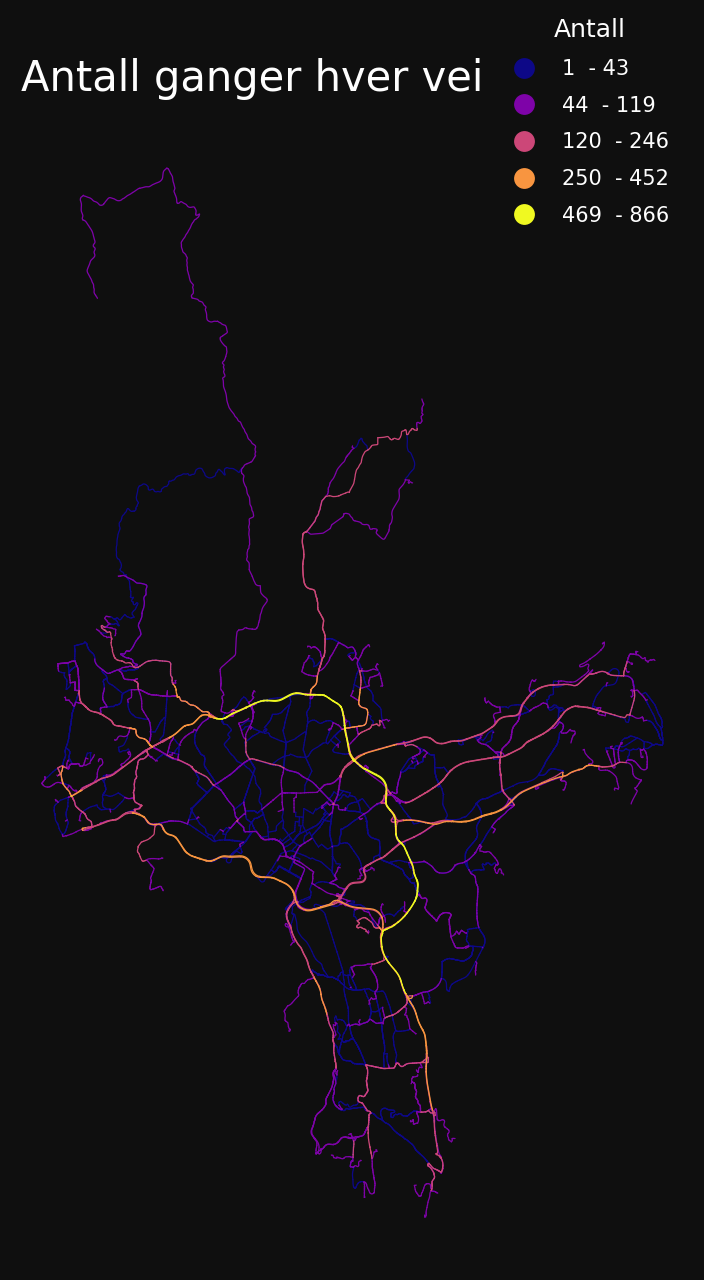

In [23]:
m = sg.ThematicMap(sg.buff(frequencies, 18), column="frequency", size=15)
m.black = True
m.cmap = "plasma" # fargepaletten
m.title = "Antall ganger hver vei ble brukt"
m.legend.title = "Antall"
m.plot()

## Finn raskeste rute
Velger ett startpunkt for illustrasjons skyld.

In [24]:
origin = bygg.loc[[2_470_929]]

In [25]:
routes = nwa.get_route(
    origins=origin,
    destinations=destinations.sample(15),
)

routes

origin  destination    minutes  \
0   2470929         1457  14.664474   
1   2470929         1444  18.748517   
2   2470929         1632  14.110939   
3   2470929         1752  14.722277   
4   2470929         1020   7.917044   
5   2470929         1223  21.819410   
6   2470929         1591  13.852895   
7   2470929         1878  11.036372   
8   2470929         1380  20.803671   
9   2470929         1388  20.083189   
10  2470929         1670  21.484691   
11  2470929         1946  23.526567   
12  2470929         1126  17.208669   
13  2470929         1192  11.125130   

                                             geometry  
0   MULTILINESTRING Z ((263438.900 6648446.900 18....  
1   MULTILINESTRING Z ((264037.800 6642863.400 38....  
2   MULTILINESTRING Z ((269478.586 6654918.544 205...  
3   MULTILINESTRING Z ((270582.000 6654081.900 193...  
4   MULTILINESTRING Z ((264737.400 6652721.700 125...  
5   MULTILINESTRING Z ((259058.039 6654755.717 204...  
6   MULTILINESTRING Z ((262841.200 6651029.403 30....  
7   MULTILINESTRING Z ((265213.400 6648357.100 59....  
8   MULTILINESTRING Z ((265008.000 6640146.900 78....  
9   MULTILINESTRING Z ((265440.600 6641324.600 113...  
10  MULTILINESTRING Z ((264094.700 6640001.000 88....  
11  MULTILINESTRING Z ((259058.039 6654755.717 204...  
12  MULTILINESTRING Z ((266612.400 6649059.000 87....  
13  MULTILINESTRING Z ((258837.000 6652306.700 67....

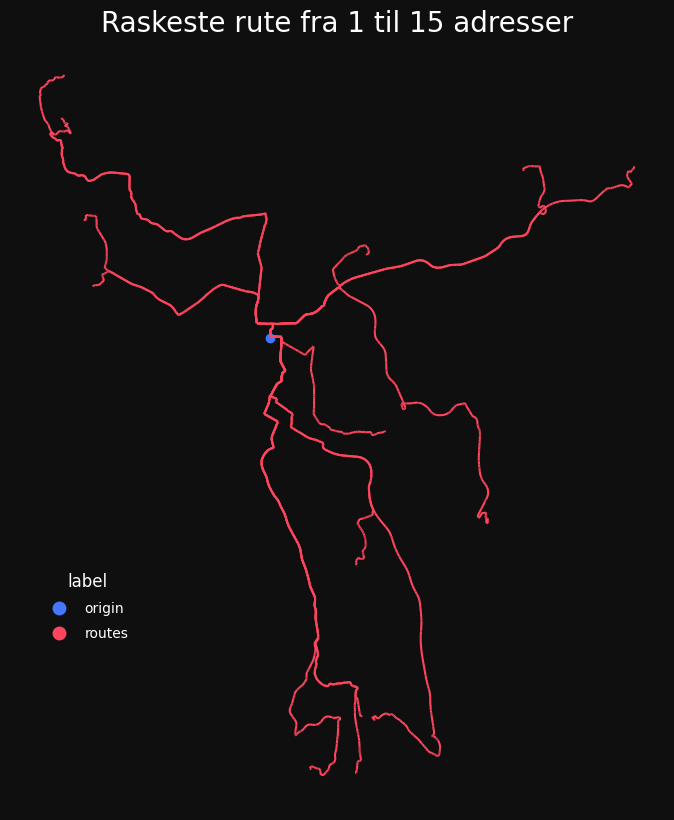

In [26]:
m = sg.ThematicMap(routes, origin, size=10)
m.black = True
m.title = "Raskeste rute fra 1 til 15 adresser"
m.plot()

### Service area

In [27]:
service_areas = nwa.service_area(
    origin,
    breaks=np.arange(1, 11),
)

service_areas

origin  minutes                                           geometry
0  2470929        1  MULTILINESTRING Z ((263020.500 6650780.000 27....
1  2470929        2  MULTILINESTRING Z ((262888.000 6651171.900 27....
2  2470929        3  MULTILINESTRING Z ((262288.231 6650825.310 40....
3  2470929        4  MULTILINESTRING Z ((262181.300 6650911.300 60....
4  2470929        5  MULTILINESTRING Z ((263821.406 6652568.059 95....
5  2470929        6  MULTILINESTRING Z ((263329.703 6652880.398 88....
6  2470929        7  MULTILINESTRING Z ((263319.400 6652894.300 87....
7  2470929        8  MULTILINESTRING Z ((266330.200 6652884.300 186...
8  2470929        9  MULTILINESTRING Z ((266598.500 6653450.000 192...
9  2470929       10  MULTILINESTRING Z ((266757.440 6653684.640 217...

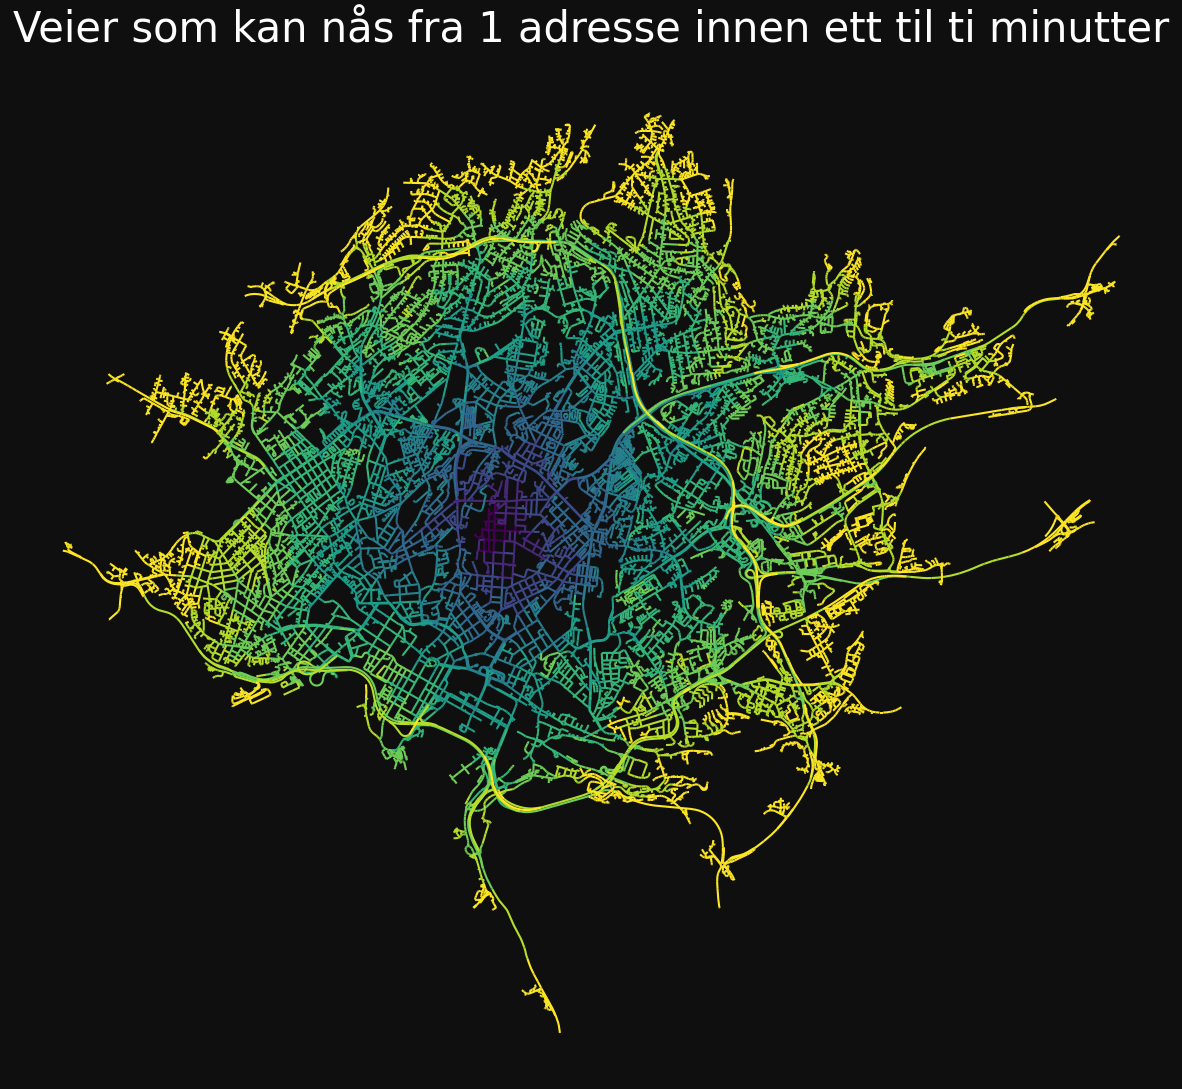

In [28]:
m = sg.ThematicMap(service_areas, column="minutes", size=15)
m.black = True
m.k = 10
m.title = "Veier som kan nås fra 1 adresse innen ett til ti minutter"
m.legend = False
m.plot()

Sjekk loggen:

In [29]:
nwa.log

endtime  minutes_elapsed                 method  origins_count  \
0 2023-04-19 10:27:18              0.1              get_route              1   
1 2023-04-19 10:27:24              0.1              get_route              1   
2 2023-04-19 10:27:44              0.2  get_route_frequencies             75   
3 2023-04-19 10:27:55              0.1              get_route              1   
4 2023-04-19 10:27:59              0.1           service_area              1   

   destinations_count  percent_missing  cost_mean  percent_bidirectional  
0                 1.0              0.0   6.354152                     87  
1                 1.0              0.0   5.357292                     87  
2                75.0              0.0   0.085069                     87  
3                15.0              0.0  16.507418                     87  
4                 NaN              0.0   5.500000                     87

### Reisetider: OD Cost Matrix

In [30]:
od = nwa.od_cost_matrix(
    origins,
    destinations,
)
od

origin  destination    minutes
0            0         1000  15.823067
1            0         1001        NaN
2            0         1002  10.502918
3            0         1003   5.233519
4            0         1004  15.694006
...        ...          ...        ...
999995     999         1995  18.231375
999996     999         1996  15.207722
999997     999         1997  13.591405
999998     999         1998  22.019851
999999     999         1999  11.571930

[1000000 rows x 3 columns]

Sjekk hvor mange prosent som mangler:

In [31]:
od.minutes.isna().mean() * 100

2.089

Kolonnene 'origin' og 'destination' bruker index-en til inputene.

Man kan derfor enkelt koble resultatene med start- og sluttpunktene:

In [32]:
origins_joinet = origins.join(od.set_index("origin"))
origins_joinet

geometry  destination    minutes
0    POINT (266614.000 6651112.000)         1000  15.823067
0    POINT (266614.000 6651112.000)         1001        NaN
0    POINT (266614.000 6651112.000)         1002  10.502918
0    POINT (266614.000 6651112.000)         1003   5.233519
0    POINT (266614.000 6651112.000)         1004  15.694006
..                              ...          ...        ...
999  POINT (264305.000 6644598.000)         1995  18.231375
999  POINT (264305.000 6644598.000)         1996  15.207722
999  POINT (264305.000 6644598.000)         1997  13.591405
999  POINT (264305.000 6644598.000)         1998  22.019851
999  POINT (264305.000 6644598.000)         1999  11.571930

[1000000 rows x 3 columns]

In [33]:
destinations_joinet = destinations.join(od.set_index("destination"))
destinations_joinet

geometry  origin    minutes
1000  POINT (267480.000 6638510.000)       0  15.823067
1000  POINT (267480.000 6638510.000)       1  20.427940
1000  POINT (267480.000 6638510.000)       2  13.603685
1000  POINT (267480.000 6638510.000)       3  12.119816
1000  POINT (267480.000 6638510.000)       4  37.676913
...                              ...     ...        ...
1999  POINT (267275.000 6641155.000)     995  10.057378
1999  POINT (267275.000 6641155.000)     996  14.986995
1999  POINT (267275.000 6641155.000)     997  12.695215
1999  POINT (267275.000 6641155.000)     998  22.559520
1999  POINT (267275.000 6641155.000)     999  11.571930

[1000000 rows x 3 columns]

Eller koble på aggregert data:

In [34]:
origins["minutes_mean"] = od.groupby("origin").minutes.mean()
origins["n_missing"] = len(origins) - od.groupby("origin", dropna=False).minutes.count()
origins

geometry  minutes_mean  n_missing
0    POINT (266614.000 6651112.000)     11.998210         10
1    POINT (262504.000 6651834.000)     13.051657         10
2    POINT (267803.000 6645192.000)     17.145483         10
3    POINT (266455.000 6648285.000)     12.332814         10
4    POINT (266424.000 6662117.000)     30.234466         10
..                              ...           ...        ...
995  POINT (265153.000 6645633.000)     14.028217         10
996  POINT (265882.000 6651289.000)     12.211888         10
997  POINT (263389.000 6641680.000)     17.857681         10
998  POINT (272332.000 6653772.000)     18.234890         10
999  POINT (264305.000 6644598.000)     16.699762         10

[1000 rows x 3 columns]

La oss undersøke hvilke punkter som har mye manglende data. 

In [35]:
# gjør kolonnen til tekst for å kunne huke av/på verdiene i explore
origins["n_missing_cat"] = origins.n_missing.astype(str)
sg.explore(origins, column="n_missing_cat")

In [36]:
sg.explore(origins, column="minutes_mean", scheme="quantiles")

Hvis man vil bruke en kolonne som id-er heller enn index-en, kan man sette index-en inni funksjonen:

In [37]:
od = nwa.od_cost_matrix(
    origins.set_index("KOMMUNENR"),
    destinations,
)

od

KeyError: "None of ['KOMMUNENR'] are in the columns"

Så kan man oppsummere for kommunene direkte:

In [ ]:
oppsummert_kommunevis = od.groupby("origin").agg(
    minutes_mean=("minutes", "mean"),
    count=("minutes", "count"),
)

oppsummert_kommunevis.index.name = "KOMMUNENR"
oppsummert_kommunevis.reset_index()

Med lines=True får man rette linjer, så man lettere kan undersøke resultatene.

In [ ]:
od = nwa.od_cost_matrix(
    origins.sample(1),
    destinations,
    lines=True
)

m = sg.ThematicMap(od, column="minutes", size=10)
m.black = True
m.title = "Reisetid fra 1 til 1000 adresser"
m.scheme = "quantiles"
m.plot()

## Finn raskeste k ruter
k = antall

In [ ]:
p1, p2 = bygg.loc[[2_470_929]], bygg.loc[[2_538_349]]

k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=1)

sg.qtm(k_routes, "k")

k_routes

Men kan stille strengere krav til hvor ulike rutene skal være. 

Med drop_middle_percent=50, fjernes midteste halvdel av ruta fra nettverket (midlertidig) før neste rute skal finnes.

In [ ]:
k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=50)

sg.qtm(k_routes, "k")

k_routes

Her fant man bare seks ulike ruter. Med drop_middle_percent=100, finner man bare én rute:

In [ ]:
k_routes = nwa.get_k_routes(p1, p2, k=10, drop_middle_percent=100)

sg.qtm(k_routes, "k", color="red")

k_routes